In [1]:
using Pkg; Pkg.activate(@__DIR__);

  Activating project at `C:\Users\djlik\OneDrive\Documents\GitHub\internal_waves_Oceananigans`


In [2]:
using Oceananigans,
      Oceananigans.Units
using CUDA

[ Info: Oceananigans will use 4 threads


In [3]:
Nx, Nz = 300, 80

architecture = CPU()

H  = 2kilometers
Lx = 1600kilometers

underlying_grid = RectilinearGrid(architecture,
                                  size = (Nx, Nz),
                                  x = (-Lx/2, Lx/2),
                                  z = (-H, 0),
                                  halo = (4, 4), # start with this commented out
                                  topology = (Periodic, Flat, Bounded))

300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

In [4]:
underlying_grid

300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

Now we want to create a bathymetry as an immersed boundary grid.

$$
h(x) = -H + h_0 \, \exp(-x^2 / 2\sigma^2)
$$

In [5]:
h₀ = 50 # m
width = 5kilometers
bump(x, y) = - H + h₀ * exp(-x^2 / 2width^2)

grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bump))

300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo:
├── immersed_boundary: GridFittedBottom(min(h)=-2.00e+03, max(h)=-1.96e+03)
├── underlying_grid: 300×1×80 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── Periodic x ∈ [-800000.0, 800000.0) regularly spaced with Δx=5333.33
├── Flat y
└── Bounded  z ∈ [-2000.0, 0.0]        regularly spaced with Δz=25.0

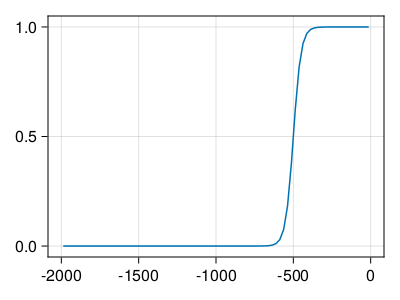

In [6]:
z = znodes(grid, Center());

using CairoMakie

fig = Figure(resolution=(400, 300))
ax = Axis(fig[1, 1])
lines!(ax, z, @. 1/2 + 1/2 * tanh((z + H/4)/50))
fig

In [7]:
xC = xnodes(grid, Center())

bottom = CUDA.@allowscalar collect(grid.immersed_boundary.bottom_height[1:Nx, 1]);

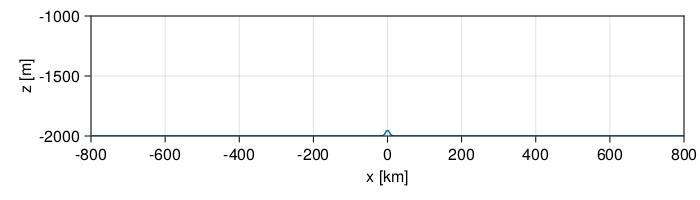

In [8]:
using CairoMakie

fig = Figure(resolution = (700, 200))
ax = Axis(fig[1, 1],
          xlabel="x [km]",
          ylabel="z [m]",
          limits=((-Lx/2e3, Lx/2e3), (-H, -H/2)))

lines!(ax, xC/1e3, bottom)

fig

The $M_2$ tidal forcing. We add forcing in the $u$-momentum equation of the form:

$$
\partial_t u = \dots + f_0 \cos(\omega_2 t)
$$

In [9]:
T₂ = 12.421hours
const ω₂ = 2π / T₂ # radians/sec

0.00014051439111137024

The excursion parameter is a nondimensional number that expresses the ratio of the flow movement due to the tide compared to the size of the width of the hill.

$$
\varepsilon = \frac{U / \omega}{\sigma}
$$

In [10]:
coriolis = FPlane(latitude = -45)

FPlane{Float64}(f=-0.000103126)

In [11]:
coriolis.f

-0.00010312607931384282

In [12]:
ε = 0.2

U_tidal = ε * ω₂ * width

coriolis = FPlane(latitude = -45)

const tidal_forcing_amplitude = U_tidal * (coriolis.f^2 - ω₂^2) / ω₂

@inline tidal_forcing(x, y, z, t) = tidal_forcing_amplitude * cos(ω₂ * t)

tidal_forcing (generic function with 1 method)

In [13]:
tidal_timescale = 1 / ω₂

Δt = 0.02 * tidal_timescale

@show prettytime(Δt)

prettytime(Δt) = "2.372 minutes"


"2.372 minutes"

In [14]:
prettytime(100000)

"1.157 days"

In [15]:
using Oceananigans.Models.HydrostaticFreeSurfaceModels: FFTImplicitFreeSurfaceSolver

fft_preconditioner = FFTImplicitFreeSurfaceSolver(grid)
free_surface = ImplicitFreeSurface(solver_method=:PreconditionedConjugateGradient, preconditioner=fft_preconditioner);

In [35]:
?ScalarDiffusivity

search: ScalarDiffusivity VerticalScalarDiffusivity HorizontalScalarDiffusivity



```
ScalarDiffusivity([time_discretization=ExplicitTimeDiscretization(),
                  formulation=ThreeDimensionalFormulation(), FT=Float64];
                  ν=0, κ=0,
                  discrete_form = false)
```

Return `ScalarDiffusivity` turbulence closure with viscosity `ν` and tracer diffusivities `κ` for each tracer field in `tracers`. If a single `κ` is provided, it is applied to all tracers. Otherwise `κ` must be a `NamedTuple` with values for every tracer individually.

# Arguments

  * `time_discretization`: either `ExplicitTimeDiscretization()` (default) or `VerticallyImplicitTimeDiscretization()`.
  * `formulation`:

      * `HorizontalFormulation()` for diffusivity applied in the horizontal direction(s)
      * `VerticalFormulation()` for diffusivity applied in the vertical direction,
      * `ThreeDimensionalFormulation()` (default) for diffusivity applied isotropically to all directions
  * `FT`: the float datatype (default: `Float64`)

# Keyword arguments

`ν` and the fields of `κ` may be constants (converted to `FT`), arrays, fields or

  * functions of `(x, y, z, t)` if `discrete_form = false`
  * functions of `(i, j, k, grid, LX, LY, LZ)` with `LX`, `LY` and `LZ` are either `Face()` or `Center()` if `discrete_form = true`.


In [16]:
ν = 2000
@inline variable_viscosity(x, y, z, t) = ν * (1/2 + 1/2 * tanh((z + H/4)/50))

horizontal_closure = HorizontalScalarDiffusivity(ν=variable_viscosity, κ = variable_viscosity)
vertical_closure = VerticalScalarDiffusivity(ν=variable_viscosity, κ = variable_viscosity)


HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=variable_viscosity (generic function with 1 method), κ=variable_viscosity (generic function with 1 method))

In [17]:
model = HydrostaticFreeSurfaceModel(grid = grid,
                                    free_surface = free_surface,
                                    coriolis = coriolis,
                                    buoyancy = BuoyancyTracer(),
                                    tracers = :b,
                                    momentum_advection = WENO(),
                                    tracer_advection = WENO(),
                                    closure = (horizontal_closure, vertical_closure),
                                    forcing = (u = tidal_forcing,))

HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
├── timestepper: QuasiAdamsBashforth2TimeStepper
├── tracers: b
├── closure: HorizontalScalarDiffusivity{ExplicitTimeDiscretization}(ν=variable_viscosity (generic function with 1 method), κ=(b=variable_viscosity (generic function with 1 method),))
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── free surface: ImplicitFreeSurface with gravitational acceleration 9.80665 m s⁻²
│   └── solver: PCGImplicitFreeSurfaceSolver
└── coriolis: FPlane{Float64}

In [18]:
model.architecture

CPU()

In [19]:
stop_time = 6T₂

simulation = Simulation(model, Δt=Δt, stop_time=stop_time)

Simulation of HydrostaticFreeSurfaceModel{CPU, ImmersedBoundaryGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 2.372 minutes
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: 3.105 days
├── Stop iteration : Inf
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [20]:
using Printf

wall_clock = Ref(time_ns())

function print_progress(sim)

    elapsed = 1e-9 * (time_ns() - wall_clock[])

    msg = @sprintf("iteration: %d, time: %s, wall time: %s, max|w|: %6.3e, m s⁻¹, next Δt: %s\n",
                   iteration(sim), prettytime(sim), prettytime(elapsed),
                   maximum(abs, sim.model.velocities.w), prettytime(sim.Δt))

    wall_clock[] = time_ns()

    @info msg

    return nothing
end

simulation.callbacks[:print_progress] = Callback(print_progress, IterationInterval(200))

Callback of print_progress on IterationInterval(200)

## Diagnostics

There are no predefine diagnostics in Oceananigans! Instead users are expected to construct their own using normal algebraic operations and calculus!

Each model has velocities and some tracers, like buoyancy $b$ or temperature and salinity ($T$ and $S$).

Let's create a few!

In [21]:
b = model.tracers.b
u, v, w = model.velocities

NamedTuple with 3 Fields on 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo:
├── u: 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
├── v: 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
└── w: 300×1×81 Field{Center, Center, Face} on ImmersedBoundaryGrid on CPU

In [22]:
U = Field(Average(u))

u′ = u - U

BinaryOperation at (Face, Center, Center)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    - at (Face, Center, Center)
    ├── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
    └── 1×1×1 Field{Nothing, Nothing, Nothing} reduced over dims = (1, 2, 3) on ImmersedBoundaryGrid on CPU

The buoyancy frequency $N^2 = \partial_z b$:

In [23]:
N² = ∂z(b)

Derivative at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    └── 300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU

The velocity vertical shear squared, $S^2 = (\partial_z u)^2 + (\partial_z v)^2$:

In [24]:
S² = @at (Center, Center, Face) ∂z(u)^2 + ∂z(v)^2

BinaryOperation at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    + at (Center, Center, Face)
    ├── ^ at (Center, Center, Face)
    │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
    │   │   └── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
    │   └── 2
    └── ^ at (Center, Center, Face)
        ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
        │   └── 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
        └── 2

And the Richardson number, $Ri = N^2 / S^2$.

In [25]:
Ri = N² / S²

BinaryOperation at (Center, Center, Face)
├── grid: 300×1×80 ImmersedBoundaryGrid{Float64, Periodic, Flat, Bounded} on CPU with 4×0×4 halo
└── tree: 
    / at (Center, Center, Face)
    ├── ∂zᶜᶜᶠ at (Center, Center, Face) via identity
    │   └── 300×1×80 Field{Center, Center, Center} on ImmersedBoundaryGrid on CPU
    └── + at (Center, Center, Face)
        ├── ^ at (Center, Center, Face)
        │   ├── ∂zᶠᶜᶠ at (Center, Center, Face) via ℑxᶜᵃᵃ
        │   │   └── 300×1×80 Field{Face, Center, Center} on ImmersedBoundaryGrid on CPU
        │   └── 2
        └── ^ at (Center, Center, Face)
            ├── ∂zᶜᶠᶠ at (Center, Center, Face) via ℑyᵃᶜᵃ
            │   └── 300×1×80 Field{Center, Face, Center} on ImmersedBoundaryGrid on CPU
            └── 2

In [26]:
name = "barotropic_tide"

simulation.output_writers[:fields] = JLD2OutputWriter(model, (; Ri, N², u′, u, w, b),
                                                      schedule = TimeInterval(15minutes),
                                                      with_halos = false,
                                                      filename = name,
                                                      overwrite_existing = true)

JLD2OutputWriter scheduled on TimeInterval(15 minutes):
├── filepath: .\barotropic_tide.jld2
├── 6 outputs: (Ri, N², u′, u, w, b)
├── array type: Array{Float64}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

## Initial conditions

In [27]:
# Initial conditions
uᵢ(x, y, z) = U_tidal

Nᵢ² = 4e-5  # [s⁻²] initial buoyancy frequency / stratification
bᵢ(x, y, z) = Nᵢ² * z

set!(model, u=uᵢ, b=bᵢ)

In [28]:
# fig = Figure(resolution = (700, 300))

# ax = Axis(fig[1, 1],
#           xlabel = "x [km]",
#           ylabel = "depth [m]")

# x, y, z = nodes(b)

# hm = heatmap!(ax, x/1e3, z, collect(interior(b, :, 1, :)))
# Colorbar(fig[1, 2], hm)

# fig

In [29]:
run!(simulation)

[ Info: Initializing simulation...
[ Info: iteration: 0, time: 0 seconds, wall time: 45.711 seconds, max|w|: 6.587e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info:     ... simulation initialization complete (13.008 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (31.215 seconds).
[ Info: iteration: 200, time: 7.158 hours, wall time: 1.496 minutes, max|w|: 1.902e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 400, time: 14.290 hours, wall time: 44.556 seconds, max|w|: 7.247e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 600, time: 21.448 hours, wall time: 45.775 seconds, max|w|: 1.069e-03, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 800, time: 1.191 days, wall time: 46.065 seconds, max|w|: 1.119e-03, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 1000, time: 1.489 days, wall time: 47.421 seconds, max|w|: 8.573e-04, m s⁻¹, next Δt: 2.372 minutes
[ Info: iteration: 1200, time: 1.786 days, wall time: 47.265 seconds, max|w|: 6.165e-04

## Reading output + visualise

Now we can load the output and visualise.

In [30]:
saved_output_filename = name * ".jld2"

u_t  = FieldTimeSeries(saved_output_filename, "u")
u′_t = FieldTimeSeries(saved_output_filename, "u′")
w_t  = FieldTimeSeries(saved_output_filename, "w")
N²_t = FieldTimeSeries(saved_output_filename, "N²")

times = u_t.times

299-element Vector{Float64}:
      0.0
    900.0
   1800.0
   2700.0
   3600.0
   4500.0
   5400.0
   6300.0
   7200.0
   8100.0
   9000.0
   9900.0
  10800.0
      ⋮
 258300.0
 259200.0
 260100.0
 261000.0
 261900.0
 262800.0
 263700.0
 264600.0
 265500.0
 266400.0
 267300.0
 268200.0

Fields live on different parts of the grid. The information is stored within each field so Oceananigans.jl gives us functionality to get the grid points where each field lives -- we don't need to do it by hand.

In [31]:
xu,  yu,  zu  = nodes(u_t[1])
xw,  yw,  zw  = nodes(w_t[1])
xN², yN², zN² = nodes(N²_t[1])

([-797333.3333333334, -792000.0, -786666.6666666666, -781333.3333333334, -776000.0, -770666.6666666666, -765333.3333333334, -760000.0, -754666.6666666666, -749333.3333333334  …  749333.3333333334, 754666.6666666666, 760000.0, 765333.3333333334, 770666.6666666666, 776000.0, 781333.3333333334, 786666.6666666666, 792000.0, 797333.3333333334], StepRangeLen(1.0, 0.0, 1), [-2000.0, -1975.0, -1950.0, -1925.0, -1900.0, -1875.0, -1850.0, -1825.0, -1800.0, -1775.0  …  -225.0, -200.0, -175.0, -150.0, -125.0, -100.0, -75.0, -50.0, -25.0, 0.0])

In [32]:
using Oceananigans.ImmersedBoundaries: mask_immersed_field!

function mask_and_get_interior(φ_t, n)
    mask_immersed_field!(φ_t[n], NaN)
    return interior(φ_t[n], :, 1, :)
end

mask_and_get_interior (generic function with 1 method)

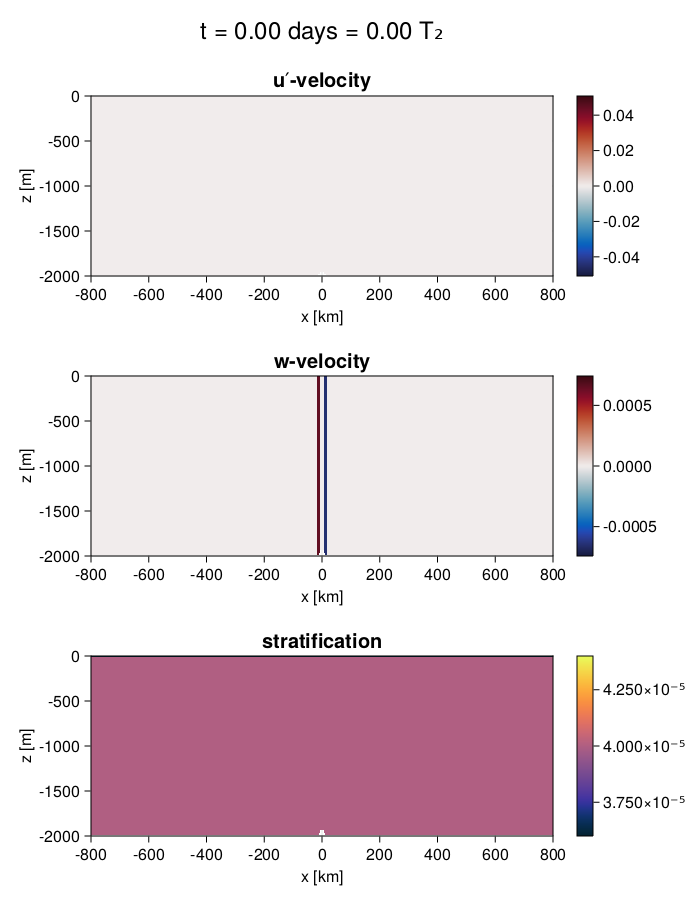

In [33]:
n = Observable(1)

title = @lift @sprintf("t = %1.2f days = %1.2f T₂", round(times[$n]/day, digits=2) , round(times[$n]/T₂, digits=2))

u′ₙ = @lift mask_and_get_interior(u′_t, $n)
wₙ  = @lift mask_and_get_interior(w_t, $n)
N²ₙ = @lift mask_and_get_interior(N²_t, $n)

axis_kwargs = (xlabel = "x [km]",
               ylabel = "z [m]",
               limits = ((-Lx/2e3, Lx/2e3), (-H, 0)),
               titlesize = 20)

ulim   = 0.5 * maximum(abs, u_t[end])
wlim   = maximum(abs, w_t[end])

fig = Figure(resolution = (700, 900))

ax_u = Axis(fig[2, 1];
            title = "u′-velocity", axis_kwargs...)

ax_w = Axis(fig[3, 1];
            title = "w-velocity", axis_kwargs...)

ax_N² = Axis(fig[4, 1];
             title = "stratification", axis_kwargs...)

fig[1, :] = Label(fig, title, fontsize=24, tellwidth=false)

hm_u = heatmap!(ax_u, xu/1e3, zu, u′ₙ;
                colorrange = (-ulim, ulim),
                colormap = :balance)
Colorbar(fig[2, 2], hm_u)

hm_w = heatmap!(ax_w, xw/1e3, zw, wₙ;
                colorrange = (-wlim, wlim),
                colormap = :balance)
Colorbar(fig[3, 2], hm_w)

hm_N² = heatmap!(ax_N², xN²/1e3, zN², N²ₙ;
                 colorrange = (0.9Nᵢ², 1.1Nᵢ²),
                 colormap = :thermal)
Colorbar(fig[4, 2], hm_N²)

fig

In [34]:
@info "Making an animation from saved data..."

frames = 1:length(times)

CairoMakie.record(fig, name * ".mp4", frames, framerate=24) do i
    msg = string("Plotting frame ", i, " of ", frames[end])
    print(msg * " \r")
    n[] = i
end

[ Info: Making an animation from saved data...


"barotropic_tide.mp4"

![](barotropic_tide.mp4)